In [1]:
import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import locatingFuncs as lF
import illustrisFuncs as iF
import funcs
import matplotlib as mpl
from matplotlib.patches import Rectangle
from os.path import isfile

import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

plt.style.use('fancy_plots2.mplstyle')

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

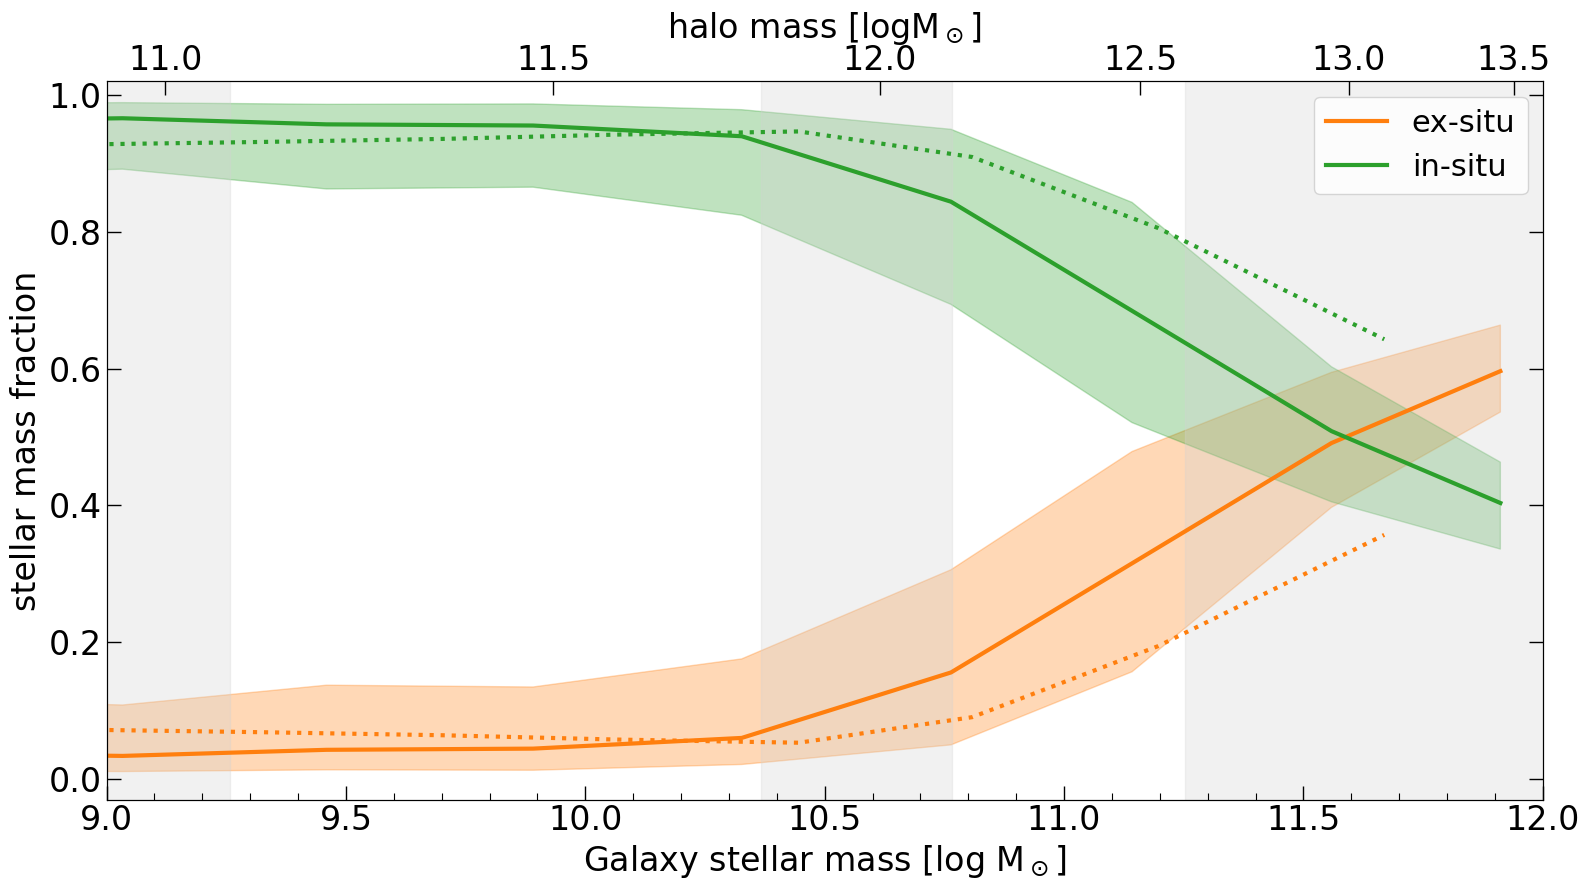

In [5]:
fig_snap = 99

f = h5py.File(basePath[:-6]+f'postprocessing/StellarAssembly/galaxies_0{fig_snap}.hdf5','r')
stellar_mass = f['StellarMassTotal'][:]
exsitu_stellar_mass = f['StellarMassExSitu'][:]

frac = exsitu_stellar_mass[np.where(stellar_mass>0)[0]] / stellar_mass[np.where(stellar_mass>0)[0]]
stellar_mass = np.log10(stellar_mass[np.where(stellar_mass>0)[0]] * 1e10/h_const)
f.close()

exsm_med, exfrac_med, exy16, exy84 =  funcs.binData_med(stellar_mass, frac, 20)
insm_med, infrac_med, iny16, iny84 =  funcs.binData_med(stellar_mass, 1 - frac, 20)

order = np.argsort(stellar_mass)
stellar_mass = stellar_mass[order]
frac = frac[order]

mask = np.where(stellar_mass > 8.5)

fig, ax = plt.subplots(1,1)
# plt.hist2d(stellar_mass[mask],frac[mask], cmap = 'Blues',norm = mpl.colors.LogNorm(), bins = (128,64))
# plt.colorbar(label='number of galaxies per bin')
ax.plot(exsm_med,exfrac_med,color = 'tab:orange', label = 'ex-situ')
ax.plot(insm_med,infrac_med,color = 'tab:green', label = 'in-situ')
ax.fill_between(exsm_med, exy16,exy84,alpha = 0.3,color = 'tab:orange')
ax.fill_between(insm_med, iny16,iny84,alpha = 0.3,color = 'tab:green')

plt.legend()
plt.xlim(9,12)
plt.ylim(-0.03,1.02)

fig_snap = 33

f = h5py.File(basePath[:-6]+f'postprocessing/StellarAssembly/galaxies_0{fig_snap}.hdf5','r')
stellar_mass = f['StellarMassTotal'][:]
exsitu_stellar_mass = f['StellarMassExSitu'][:]

frac = exsitu_stellar_mass[np.where(stellar_mass>0)[0]] / stellar_mass[np.where(stellar_mass>0)[0]]
stellar_mass = np.log10(stellar_mass[np.where(stellar_mass>0)[0]] * 1e10/h_const)
f.close()

exsm_med, exfrac_med, exy16, exy84 =  funcs.binData_med(stellar_mass, frac, 20)
insm_med, infrac_med, iny16, iny84 =  funcs.binData_med(stellar_mass, 1 - frac, 20)

order = np.argsort(stellar_mass)
stellar_mass = stellar_mass[order]
frac = frac[order]

mask = np.where(stellar_mass > 8.5)

ax.plot(exsm_med,exfrac_med,color = 'tab:orange', linestyle = 'dotted')
ax.plot(insm_med,infrac_med,color = 'tab:green', linestyle = 'dotted')


group_m = np.array([6.86093282699585, 7.398449420928955, 7.901801109313965, 8.393900871276855, 8.886045455932617,\
                    9.339580535888672, 9.809768676757812, 10.323699951171875, 10.840004920959473, 11.344971656799316,\
                    11.868677139282227, 12.379907608032227, 12.879098892211914, 13.441740036010742, 13.891986846923828])
gal_m = np.array([4.742977619171143, 4.718081474304199, 4.761687278747559, 4.795966625213623, 4.861518859863281,\
                  5.147671699523926, 6.013262748718262, 7.66148042678833, 8.850899696350098, 9.708621978759766,\
                  10.465829849243164, 11.046808242797852, 11.511899948120117, 11.899462699890137, 12.20790958404541])
secax = ax.twiny()
from scipy import interpolate
f_interp = interpolate.interp1d(group_m, gal_m)
new_tick_locations = np.array([11.,11.5,12.,12.5,13.,13.5])
secax.set_xlim(ax.get_xlim())
secax.set_xticks(f_interp(new_tick_locations))
secax.set_xticklabels(new_tick_locations)
secax.minorticks_off()
secax.set_xlabel(r'halo mass [log$\rm{M}_\odot$]')

rec_dwarf = Rectangle((f_interp(10.8),-0.1),0.5,1.2, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_dwarf)
rec_mw = Rectangle((f_interp(11.8),-0.1),0.4,1.2, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_mw)
rec_group = Rectangle((f_interp(12.6),-0.1),0.8,1.2, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_group)


ax.set_xlabel(r'Galaxy stellar mass [log $\rm{M}_\odot$]')
ax.set_ylabel('stellar mass fraction')
fig.tight_layout()
#plt.grid()
#plt.savefig('pics/ex-situ_in-situ_mass_fraction/ex-in-situ_mass_frac_wo_histo_w_sigma.pdf',format = 'pdf')

In [30]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
f = h5py.File(basePath[:-6]+f'postprocessing/StellarAssembly/galaxies_099.hdf5','r')
stellar_mass_z0 = f['StellarMassTotal'][:] * 1e10/h_const
exsitu_stellar_mass_z0 = f['StellarMassExSitu'][:] * 1e10/h_const
f.close()

f = h5py.File(basePath[:-6]+f'postprocessing/StellarAssembly/galaxies_033.hdf5','r')
stellar_mass_z2 = f['StellarMassTotal'][:] * 1e10/h_const
exsitu_stellar_mass_z2 = f['StellarMassExSitu'][:] * 1e10/h_const
f.close()

In [31]:
numSubs = stellar_mass_z0.shape[0]
trees = loadMPBs(basePath, 99, ids = np.arange(numSubs),fields = ['SubfindID'])
fracs = np.zeros(numSubs)
#find missing trees
missing = []
tree_check = list(trees)
counter = 0
for i in range(numSubs):
    if i != tree_check[counter]:
        missing.append(i)
        i+=1
        continue
    counter+=1
for i in range(numSubs):
    if i in missing:
        fracs[i] = np.nan
        continue
    if trees[i]['count'] > 99-33:
        target_id = trees[i]['SubfindID'][99-33]
    else:
        fracs[i] = np.nan
        continue
    sub_mass_z2 = np.take(stellar_mass_z2,target_id,mode='clip')
    sub_exsitu_mass_z2 = np.take(exsitu_stellar_mass_z2,target_id,mode='clip')
    mass_growth = stellar_mass_z0[i] - sub_mass_z2
    exsitu_mass_growth = exsitu_stellar_mass_z0[i] - sub_exsitu_mass_z2
    if mass_growth > 0:
        fracs[i] = exsitu_mass_growth/mass_growth

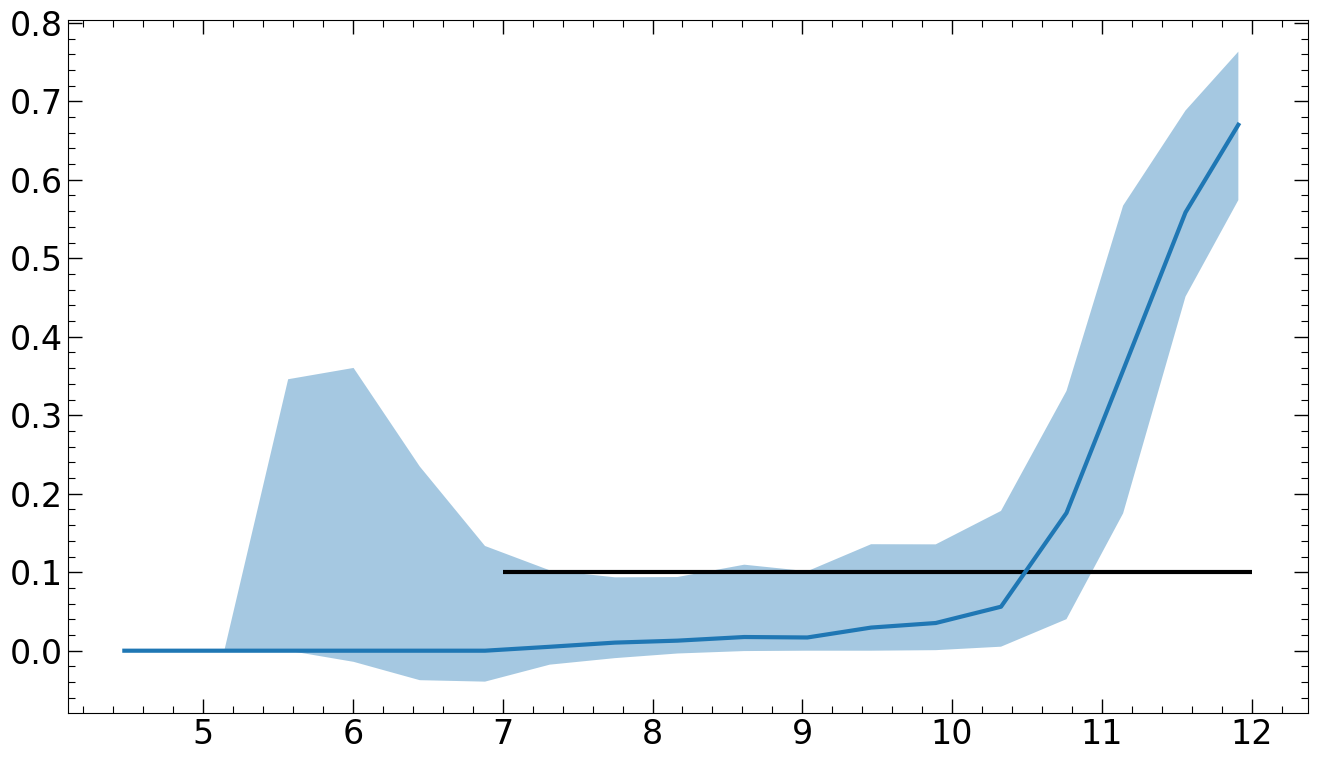

In [33]:
gal_mass = np.log10(stellar_mass_z0[np.where(stellar_mass_z0 > 0)])
growth_fracs = fracs[np.where(stellar_mass_z0 > 0)]
bins, binned_fracs,var16,var84=  funcs.binData_med(gal_mass, growth_fracs, 20)

plt.plot(bins,binned_fracs)
plt.fill_between(bins,var16,var84,alpha = 0.4)
plt.hlines(0.1,7,12)

In [8]:
print(exsitu_stellar_mass_z0.shape[0], exsitu_stellar_mass_z2.shape[0])

22869 29611


groups = il.groupcat.loadHalos(basePath, fig_snap, fields = ['Group_M_Crit200', 'GroupFirstSub'])
sub_masses = il.groupcat.loadSubhalos(basePath, fig_snap, fields = ['SubhaloMassType'])[:,4] * 1e10/h_const
sub_masses_total = il.groupcat.loadSubhalos(basePath, fig_snap, fields = ['SubhaloMass']) * 1e10/h_const

#sub_ids = groups['GroupFirstSub']
sub_ids = np.arange(sub_masses.shape[0])
sub_masses = sub_masses[sub_ids]

halo_masses = iF.group_masses_for_sub_ids(groups['Group_M_Crit200'] * 1e10/h_const, sub_masses_total,\
                                          groups['GroupFirstSub'], sub_ids)

mask = np.where(sub_masses > 0)
sub_masses = np.log10(sub_masses[mask])
halo_masses = np.log10(halo_masses[mask])
order_subs = np.argsort(sub_masses)
order_groups = np.argsort(halo_masses)
#sub_masses = sub_masses[order]
#group_masses = group_masses[order]

In [40]:
@jit(nopython = True)
def ex_in_frac_binning(starType, distance, numBins, max_dist): 
    minVal = 0
    maxVal = max_dist
    
    binWidth = (maxVal - minVal) / numBins
    
    yMed = np.zeros(numBins)
    
    for j in range(numBins):
        relInd = np.where(np.logical_and(distance >= minVal + j*binWidth, distance < minVal + (j+1)*binWidth))[0]
        if(relInd.size>0):
            insitu = np.where(starType[relInd] == 1)[0].shape[0]
            exsitu = np.where(starType[relInd] == 0)[0].shape[0]
            yMed[j] = exsitu/(insitu + exsitu)# if insitu > 0 else np.nan
            
    return yMed

In [35]:
@jit(nopython = True, parallel = True)
def compute_profiles(sub_ids, num_bins, offsets, numPart_stars, sub_pos, starType, star_pos, boxSize,\
                                    group_R_Crit200, num_gmcrit200):
    sub_profiles = np.zeros((sub_ids.shape[0],num_bins))
    
    for i in nb.prange(sub_ids.shape[0]):
        offset = offsets[i]
        num_stars = numPart_stars[i]
        subhalo_pos = sub_pos[i,:]
        indcs = np.arange(offset,offset + num_stars)
        starType_sub = starType[indcs]        
        distances = funcs.dist_vector_nb(subhalo_pos,star_pos[indcs],boxSize) #/h_const
        
        #bin until max_dist times the stellar halfmass radius is reached
        max_dist = num_gmcrit200 * group_R_Crit200[i]#subs['SubhaloHalfmassRadType'][sub_ids[i],4]
        sub_profiles[i,:] = ex_in_frac_binning(starType_sub, distances, num_bins, max_dist)
    return sub_profiles

In [36]:
def exsitu_radial_profile(basePath, snap, sub_ids, group_R_Crit200, num_bins = 10, num_gmcrit200 = 2,\
                          star_pos = 0, subs = 0):
    """Computes (average) radial profile of given subhalos at specific snapshot up until max_dist times the
    stellar halfmass radius."""
    boxSize = il.groupcat.loadHeader(basePath,snap)['BoxSize']
    h_const = il.groupcat.loadHeader(basePath,snap)['HubbleParam']
    
    f = h5py.File(basePath[:-6]+'postprocessing/StellarAssembly/stars_' + str(snap).zfill(3) + '.hdf5','r')
    starType = f['InSitu'][:]
    f.close()
    
    g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_' + str(snap).zfill(3) + '.hdf5','r')
    offset = g['Subhalo/SnapByType'][sub_ids,4]
    g.close()
    
    numPart_stars = subs['SubhaloLenType'][sub_ids,4]
    sub_pos = subs['SubhaloPos'][sub_ids,:]
    
    sub_profiles = compute_profiles(sub_ids, num_bins, offset, numPart_stars, sub_pos, starType, star_pos, boxSize,\
                                    group_R_Crit200, num_gmcrit200)
    
#     sub_profiles = np.zeros((sub_ids.shape[0],num_bins))
    
#     for i in range(sub_ids.shape[0]):
#         offset = il.snapshot.getSnapOffsets(basePath, snap, sub_ids[i], 'Subhalo')['offsetType'][4]
#         numPart_stars = subs['SubhaloLenType'][sub_ids[i],4]
#         sub_pos = subs['SubhaloPos'][sub_ids[i],:]
#         indcs = np.arange(offset,offset + numPart_stars)
#         starType_sub = starType[indcs]        
#         distances = funcs.dist_vector_nb(sub_pos,star_pos[indcs],boxSize) #/h_const
        
#         #bin until max_dist times the stellar halfmass radius is reached
#         max_dist = num_gmcrit200 * group_R_Crit200[i]#subs['SubhaloHalfmassRadType'][sub_ids[i],4]
#         sub_profiles[i,:] = ex_in_frac_binning(starType_sub, distances, num_bins, max_dist)
    
    return sub_profiles

In [37]:
star_pos_99 = il.snapshot.loadSubset(basePath, 99, 4, fields = ['Coordinates'])
star_pos_33 = il.snapshot.loadSubset(basePath, 33, 4, fields = ['Coordinates'])

1/6
2/6
3/6
4/6
5/6
6/6
CPU times: user 1min 19s, sys: 16.9 s, total: 1min 36s
Wall time: 1min 38s


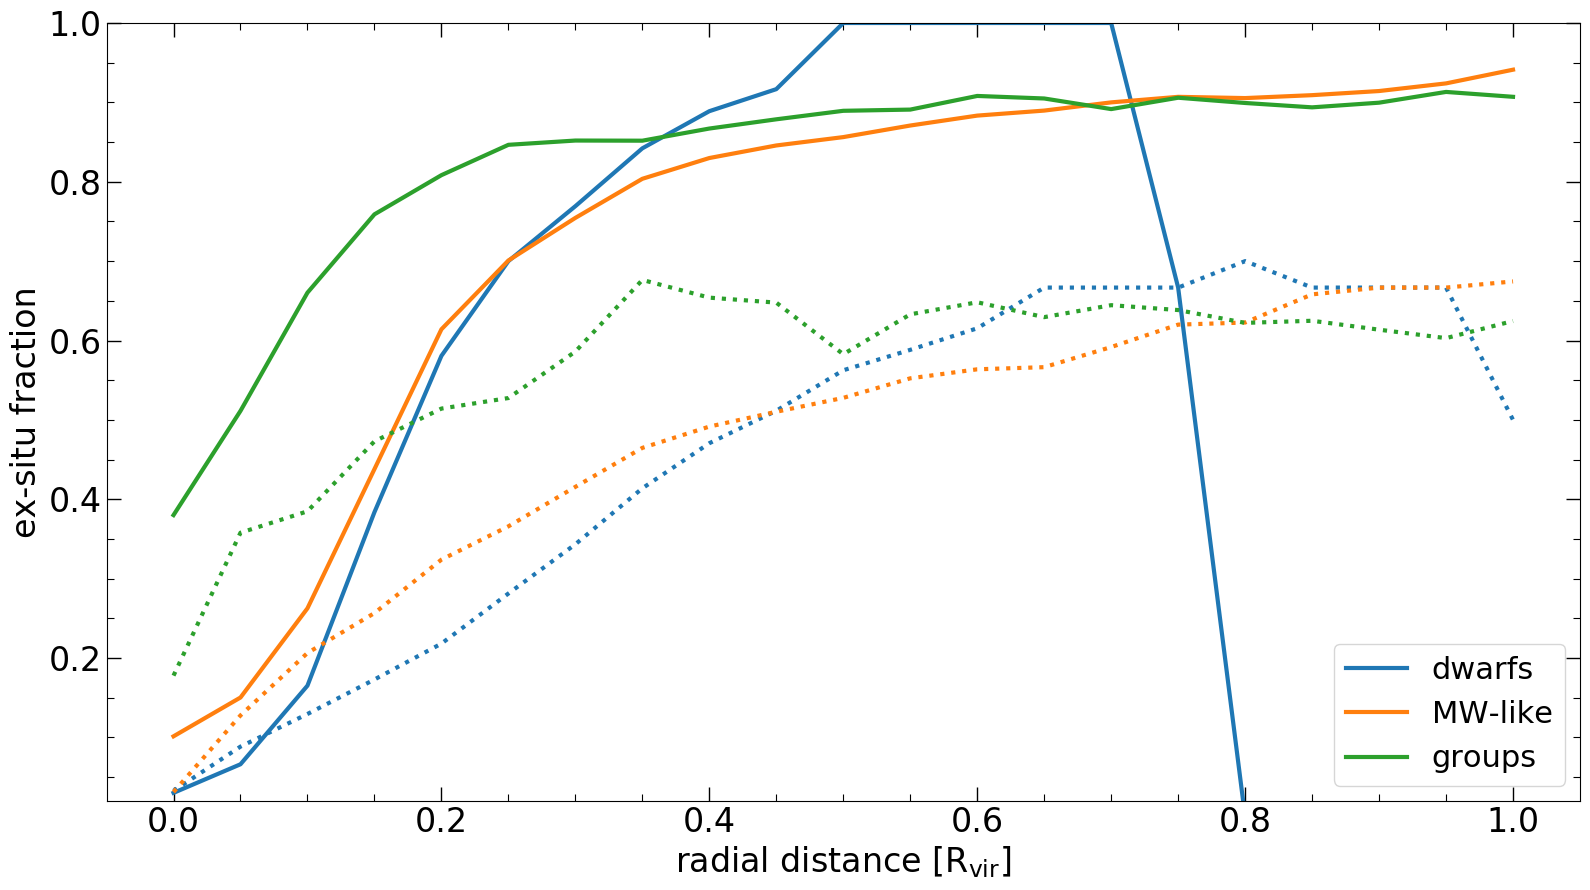

In [42]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
start_snap = 99
h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]

groupRcrit200_dwarves = groups['Group_R_Crit200'][dwarf_ids]
groupRcrit200_mw = groups['Group_R_Crit200'][mw_ids]
groupRcrit200_groups = groups['Group_R_Crit200'][group_ids]

numBins = 21
num_gmcrit200 = 1
dist_bins = np.linspace(0,num_gmcrit200,numBins)

star_pos = star_pos_99
subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloPos','SubhaloLenType','SubhaloHalfmassRadType'])
sub_profiles_dwarves = exsitu_radial_profile(basePath, start_snap, sub_ids_dwarves, groupRcrit200_dwarves,\
                                             numBins, num_gmcrit200, star_pos, subs)
print('1/6', flush = True)
sub_profiles_mw = exsitu_radial_profile(basePath, start_snap, sub_ids_mw, groupRcrit200_mw, numBins, num_gmcrit200,\
                                        star_pos, subs)
print('2/6', flush = True)
sub_profiles_groups = exsitu_radial_profile(basePath, start_snap, sub_ids_groups, groupRcrit200_groups,\
                                            numBins, num_gmcrit200, star_pos, subs)
print('3/6', flush = True)

fig, ax = plt.subplots(1,1)
ax.plot(dist_bins, np.nanmedian(sub_profiles_dwarves,axis = 0),label = 'dwarfs', color = 'C0')
ax.plot(dist_bins, np.nanmedian(sub_profiles_mw,axis = 0),label = 'MW-like', color = 'C1')
ax.plot(dist_bins, np.nanmedian(sub_profiles_groups,axis = 0),label = 'groups', color = 'C2')
ax.legend(loc = 'lower right')

start_snap = 33
h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]

groupRcrit200_dwarves = groups['Group_R_Crit200'][dwarf_ids]
groupRcrit200_mw = groups['Group_R_Crit200'][mw_ids]
groupRcrit200_groups = groups['Group_R_Crit200'][group_ids]

subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloPos','SubhaloLenType','SubhaloHalfmassRadType'])
del star_pos
star_pos = star_pos_33
sub_profiles_dwarves = exsitu_radial_profile(basePath, start_snap, sub_ids_dwarves, groupRcrit200_dwarves,\
                                             numBins, num_gmcrit200, star_pos, subs)
print('4/6', flush = True)
sub_profiles_mw = exsitu_radial_profile(basePath, start_snap, sub_ids_mw, groupRcrit200_mw, numBins, num_gmcrit200,\
                                        star_pos, subs)
print('5/6', flush = True)
sub_profiles_groups = exsitu_radial_profile(basePath, start_snap, sub_ids_groups, groupRcrit200_groups,\
                                            numBins, num_gmcrit200, star_pos, subs)
print('6/6', flush = True)

ax.plot(dist_bins, np.nanmedian(sub_profiles_dwarves,axis = 0), color = 'C0', linestyle = 'dotted')
ax.plot(dist_bins, np.nanmedian(sub_profiles_mw,axis = 0), color = 'C1', linestyle = 'dotted')
ax.plot(dist_bins, np.nanmedian(sub_profiles_groups,axis = 0), color = 'C2', linestyle = 'dotted')

#ax.set_yscale('log')
ax.set_xlabel(r'radial distance [$\rm{R}_{\rm{vir}}$]')
ax.set_ylabel('ex-situ fraction')
ax.set_ylim(2e-2,1)
fig.tight_layout()

# plt.savefig('pics/ex-situ_in-situ_mass_fraction/exsitu_frac_rad_profile_' + basePath[35:39] +\
#             '_new.pdf', format = 'pdf')

In [24]:
print(1 - (np.nanpercentile(sub_profiles_dwarves, 16, axis = 0))/np.nanmedian(sub_profiles_dwarves,axis = 0))

[0.76881448 0.65957316 0.70120444 0.73169306 0.67581831 0.64669261
 0.62285714 0.66666667 0.81186813 1.         1.         1.
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [9]:
%%time
#---- settings----#
halo_type = 'all'
run = 3
basePath='/virgotng/universe/IllustrisTNG/TNG50-' + str(run) + '/output'
start_snap = 99
snaps = np.array([99, 84, 67, 50, 33, 25])


h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

#introduce mass bins:
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))[0]
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))[0]
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))[0]
all_ids = np.arange(group_masses.shape[0])

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]
all_central_ids = groups['GroupFirstSub'][:]

numBins = 501
num_gmcrit200 = 5
dist_bins = np.linspace(0,num_gmcrit200,numBins)

sub_positions = h5py.File('files/'+basePath[32:39]+'/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
is_extrapolated = sub_positions['is_extrapolated'][:]
sub_positions.close()

sub_ids = sub_ids_mw if halo_type == 'mw' else sub_ids_dwarves if halo_type == 'dwarves' else sub_ids_groups if\
halo_type == 'groups' else all_central_ids

ids = mw_ids if halo_type == 'mw' else dwarf_ids if halo_type == 'dwarves' else group_ids if halo_type == 'groups'\
else all_ids

group_R_crit200 = groups['Group_R_Crit200'][ids] / h_const

# mass_mean, profiles, sub_means, extrapolated_sub_ids = AllTracerProfile_wMassBins(basePath,start_snap,snaps[0], sub_ids,\
#                                                                                  group_R_crit200, numBins,num_gmcrit200,\
#boxSize)

# profile_cumsum_evo = np.empty((snaps.shape[0],extrapolated_sub_ids.shape[0], numBins), dtype = float)
# mass_means = np.empty(snaps.shape[0], dtype = float)
# sub_means_evo = np.empty((snaps.shape[0], extrapolated_sub_ids.shape[0]), dtype = float)

# mass_means[0] = mass_mean
# profile_cumsum_evo[0,:,:] = np.cumsum(profiles,axis=1)
# sub_means_evo[0,:] = sub_means

# for i in range(1,snaps.shape[0]):
#     mass_mean, profiles, sub_means, _ = AllTracerProfile_wMassBins(basePath,start_snap,snaps[i], sub_ids,\
#                                                                                  group_R_crit200, numBins,num_gmcrit200,\
#boxSize)
#     mass_means[i] = mass_mean
#     profile_cumsum_evo[i,:,:] = np.cumsum(profiles,axis=1)
#     sub_means_evo[i,:] = sub_means
    
# f = h5py.File('files/'+basePath[32:39]+'/rad_prof_tracer_frac_' + halo_type + '.hdf5','w')
# ds = f.create_dataset('distance_bins',data = dist_bins)
# ds2 = f.create_dataset('snapshots',data = snaps)
# ds3 = f.create_dataset('mass_bin_means',data = mass_means)
# ds4 = f.create_dataset('cumulative_profiles',data = profile_cumsum_evo)
# ds5 = f.create_dataset('subhalo_mean_distances',data = sub_means_evo)
# f.close()

CPU times: user 25.3 ms, sys: 7.12 ms, total: 32.5 ms
Wall time: 31.6 ms


In [6]:
f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-2/cumulative_radial_profile/rad_prof_tracer_frac_new_all_98.hdf5','r')
profiles = f['cumulative_profiles'][:,:]
extrapolated_sub_ids = f['which_galaxy_ids'][:]
f.close()

print(profiles.shape)
print(extrapolated_sub_ids[np.where(extrapolated_sub_ids != -1)].shape)

(13143, 501)
(13143,)


In [3]:
def get_halfmass_radii(run, max_dist, snaps):
    """Computes the halfmass radii and estimates the formation snapshots (z at which hmr == R_vir)
    for all central galaxies."""
#     f = h5py.File('files/TNG50-' + run + '/rad_prof_tracer_frac_all.hdf5','r')
#     cumsum_profiles = f['cumulative_profiles'][:,:]
#     dist_bins = f['distance_bins'][:]
#     f.close()

    file = '/vera/ptmp/gc/olwitt/TNG50-' + run + f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_99.hdf5'
    #assert isfile(file), 'filename wrong'
    f = h5py.File(file,'r')
    profiles = f['cumulative_profiles'][:,:]
    dist_bins = f['distance_bins'][:]
    extrapolated_sub_ids = f['which_galaxy_ids'][:]
    f.close()
    
#     print(extrapolated_sub_ids.shape)
#     print(np.where(extrapolated_sub_ids == -1)[0].shape[0])
#     print(profiles.shape[0])
    
    cumsum_profiles = np.empty((snaps.shape[0],profiles.shape[0],profiles.shape[1]), dtype = float)
#     print('todo: ',cumsum_profiles.shape[1])
    for i in range(snaps.size):
        f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
                      f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_{snaps[i]}.hdf5','r')
        profiles = f['cumulative_profiles'][:,:]
        extrapolated_sub_ids = f['which_galaxy_ids'][:]
        f.close()
        if profiles.shape[0] != cumsum_profiles.shape[1]:
            #if there are less profiles in the snapshot file than at snap99: add -1 arrays so the shapes match again
#             print('have: ', profiles.shape[0])
#             print('wrong: ', np.where(extrapolated_sub_ids == -1)[0].shape[0])
            diff = cumsum_profiles.shape[1] - profiles.shape[0]
#             print('difference: ',diff)
            counter = 0
            for j in range(cumsum_profiles.shape[1]):
                if extrapolated_sub_ids[j] == -1:
                    cumsum_profiles[i,j,:] = np.full(cumsum_profiles.shape[2],-1)
                    diff -= 1
                else:
                    cumsum_profiles[i,j,:] = profiles[counter,:]
                    counter += 1
#             assert counter == profiles.shape[0]+1 and diff == 0, 'filling went wrong'
        else:
            cumsum_profiles[i,:,:] = profiles
        print('snap ',snaps[i],' loaded;')
    del profiles
    
    print('loading complete...')
    
    hmr = np.zeros((cumsum_profiles.shape[0],cumsum_profiles.shape[1]))
    
    hmr = hmrs(hmr,cumsum_profiles,dist_bins)
    
    print('halfmass radii computation complete...')
    
    #now compute formation redshifts, i.e. the interpolated redshift at which the halfmass radius is equal to R_vir
    form_snap = formation_snapshot(hmr, snaps)
    
    print('formation snapshot computation complete...')
    
    f = h5py.File('files/'+basePath[32:39]+f'/hmr_form_snap_{max_dist}.hdf5','w')
    ds = f.create_dataset('halfmass_radii',data = hmr)
    ds2 = f.create_dataset('formation_snapshots',data = form_snap)
    f.close()
    
    
    return hmr, form_snap

In [4]:
@jit(nopython=True, parallel = True)
def formation_snapshot(hmr, snaps):
    form_snap = np.zeros(hmr.shape[1])
    for i in nb.prange(hmr.shape[1]):
        ind = np.where(hmr[:,i] == 1)[0]
        if ind.size > 0:
            if ind.size == 1:
                form_snap[i] = snaps[ind[0]]
            else:
                form_snap[i] = np.nanmean(snaps[ind.flatten()])
            continue
        r_dist = 1 - hmr[:,i]
        if np.all(r_dist > 1):
            form_snap[i] = -1
            continue
        ind = np.where(r_dist[1:] * r_dist[:-1] < 0)[0]
        if ind.size == 0: #if there's no match at all, put snapshot 0 => most likely the hmr hasn't reached one yet
            form_snap[i] = snaps[-1]
            continue
#         if ind.size > 1 and funcs.areEqual(ind,np.arange(ind[0],ind[-1]+1)):
#             ind = np.array([int((ind[-1] + ind[0])/2)])

        m = (hmr[ind[0]+1,i] - hmr[ind[0],i])/(snaps[ind[0]+1] - snaps[ind[0]])
        form_snap[i] = (1 - hmr[ind[0],i])/m + snaps[ind[0]]
    return form_snap

In [5]:
@jit(nopython = True, parallel = True)
def hmrs(res, cumsum_profiles, dist_bins):
    for i in nb.prange(cumsum_profiles.shape[0]):
        for j in nb.prange(cumsum_profiles.shape[1]): #for all remaining centrals
            if np.all(cumsum_profiles[i,j,:] == -1):
                res[i,j] = -1
                continue
            ind, next_too = funcs.data_intersect_value(cumsum_profiles[i,j,:],0.5)
            if not next_too:
                res[i,j] = np.mean(dist_bins[ind])
            else:
                if ind.size > 1:
                    res[i,j] = np.nanmean(np.array([dist_bins[ind[0]], dist_bins[ind[0]+1]]))
                else:
                    a = np.concatenate((dist_bins[ind].flatten(), dist_bins[ind+1].flatten()))
                    res[i,j] = np.nanmean(a)
    return res

## initialize arrays and compute hmr

In [4]:
%%time
run = '1'
start_snap = 99
# f = h5py.File('files/TNG50-' + run + '/rad_prof_tracer_frac_all.hdf5','r')
# dist_bins = f['distance_bins'][:]
# snaps = f['snapshots'][:]
# cumsum_profiles = f['cumulative_profiles'][:,:,:]
# extrapolated_sub_ids = f['which_galaxy_ids'][:]
# f.close()

basePath='/virgotng/universe/IllustrisTNG/TNG50-' + run + '/output'

h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']

#introduce mass bins:
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))[0]
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))[0]
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))[0]
all_ids = np.arange(group_masses.shape[0])

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]
all_central_ids = groups['GroupFirstSub'][:]

print('groupcat loading complete...')

snaps = np.arange(99,0,-1)
#hmr, form_snap = get_halfmass_radii(run,'new',snaps)

z = iF.give_z_array(basePath)

groupcat loading complete...
CPU times: user 1.51 s, sys: 303 ms, total: 1.81 s
Wall time: 20.6 s


In [98]:
halo_type='m'

sub_ids = sub_ids_mw if halo_type == 'mw' else sub_ids_dwarves if halo_type == 'dwarves' else sub_ids_groups if\
halo_type == 'groups' else all_central_ids

ids = mw_ids if halo_type == 'mw' else dwarf_ids if halo_type == 'dwarves' else group_ids if halo_type == 'groups'\
else all_ids

group_R_crit200 = groups['Group_R_Crit200'][ids] / h_const

mask = tF.getIndices(tF.getIndices(sub_ids, all_central_ids),extrapolated_sub_ids)
hmr = hmr[:,mask]
form_snap = form_snap[mask]
#print(hmr)
# plt.hlines(0.5,-50,5*np.mean(locals()['groupRcrit200_'+halo_type]),linestyle='-.')
# for i in range(6):
# #     mask = np.where(cumsum_profiles[i,:,10] != 0)[0]
#     plt.plot(dist_bins*np.mean(locals()['groupRcrit200_'+halo_type]),\
#              np.mean(cumsum_profiles[i,:,:],axis = 0), label = f'z = {z[i]:.1f}')
#     plt.scatter(np.nanmean(hmr[i,:]*np.mean(locals()['groupRcrit200_'+halo_type])),0.5)

# plt.legend()

38.0


(-0.02, 1.02)

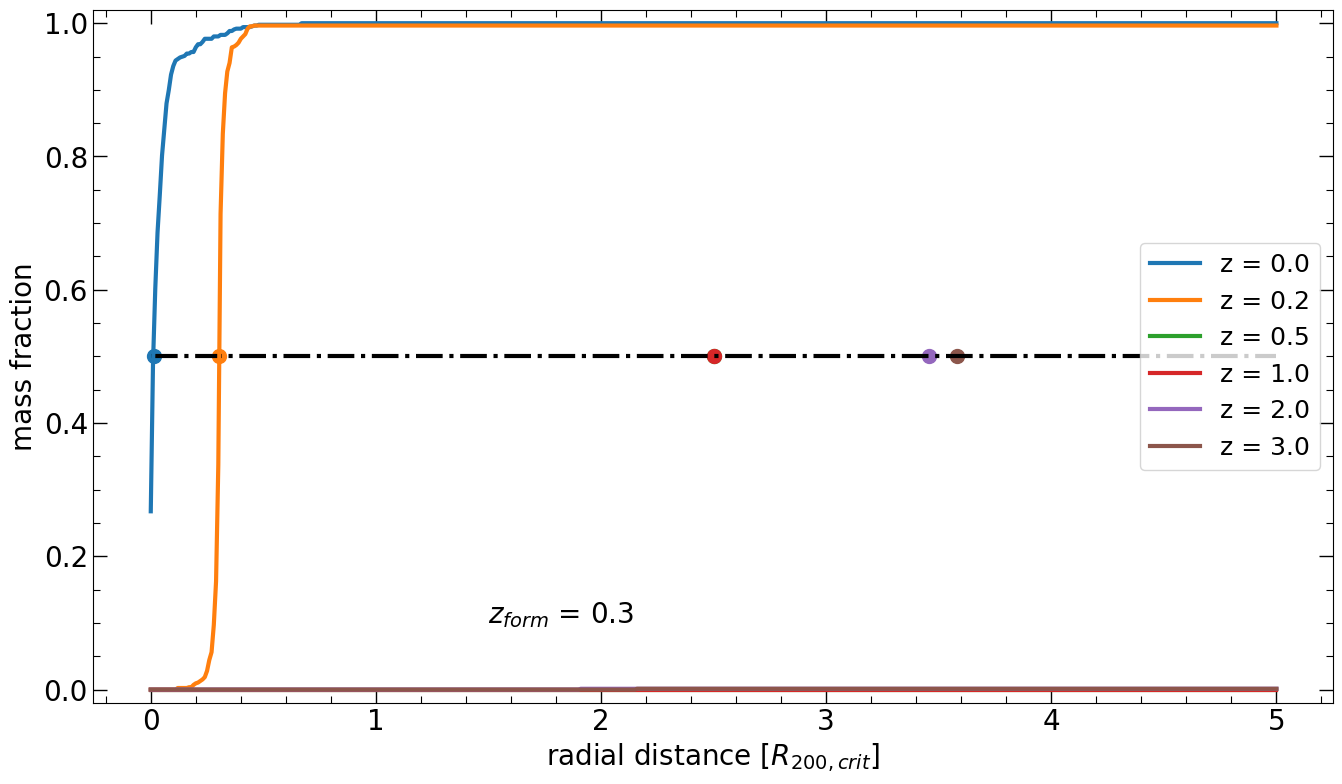

In [103]:
plt.hlines(0.5,0,5,linestyle='-.')
sub_id = 10
z_snaps = np.zeros(snaps.size)
for i in range(6):
#     mask = np.where(cumsum_profiles[i,:,10] != 0)[0]
    z_snaps[i] = il.groupcat.loadHeader(basePath,snaps[i])['Redshift']
    plt.plot(dist_bins, cumsum_profiles[i,sub_id,:], label = f'z = {z_snaps[i]:.1f}')
    plt.scatter(np.nanmedian(hmr[i,sub_id]),0.5)
#plt.scatter(hmr[5,:],0.5*np.ones(hmr[5,:].size),alpha = 0.1,color = 'tab:brown')
print(np.floor(np.nanmedian(form_snap)))
plt.legend()
plt.xlabel('radial distance [$R_{200,crit}$]')
plt.ylabel('mass fraction')
plt.text(1.5,0.1,r'$z_{form}$ = ' + f'{z[99-form_snap[sub_id].astype(int)]:.1f}', size = 20)
plt.ylim(-0.02,1.02)
#plt.savefig('pics/test_profile.pdf',format = 'pdf')

In [7]:
file = '/vera/ptmp/gc/olwitt/TNG50-2/cumulative_radial_profile/rad_prof_tracer_frac_new_all_99.hdf5'
#assert isfile(file), 'filename wrong'
f = h5py.File(file,'r')
print(f.keys())
f.close()

<KeysViewHDF5 ['cumulative_profiles', 'distance_bins', 'mass_bin_means', 'subhalo_mean_distances', 'which_galaxy_ids']>


0.0 15.0


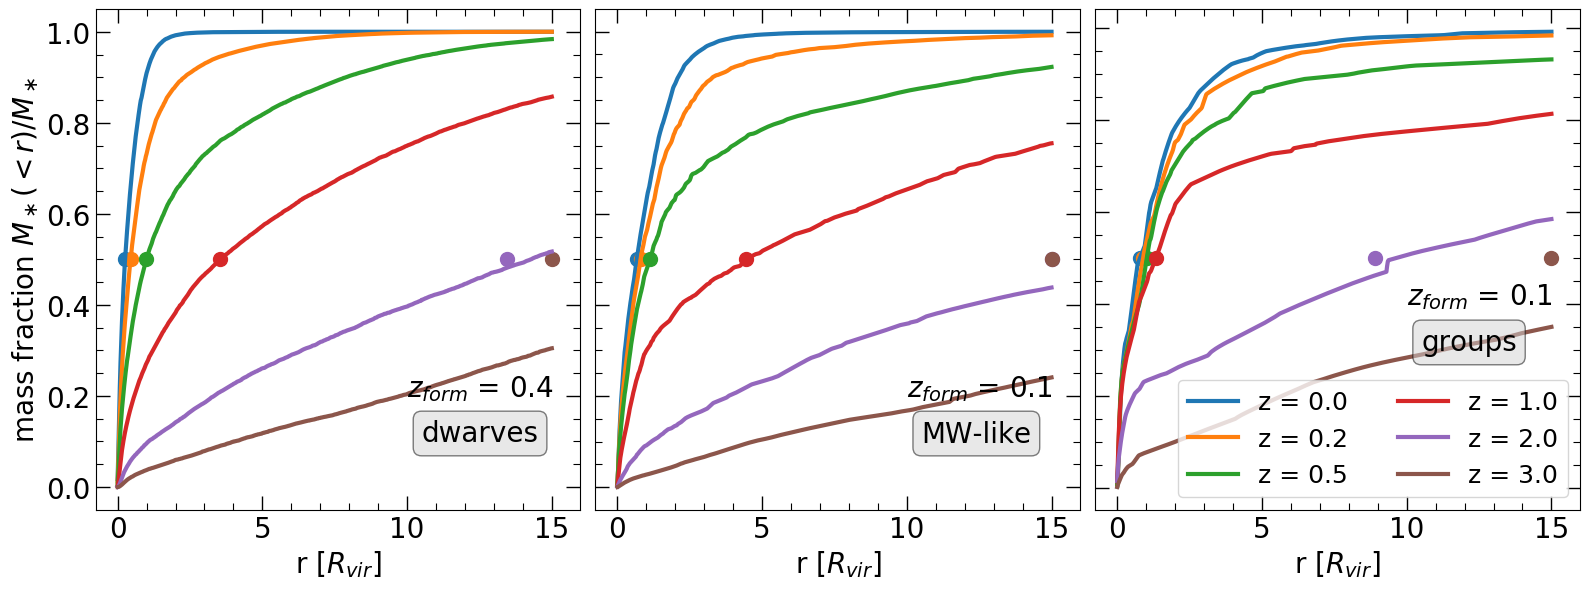

In [7]:
max_dist = 'new'
file = '/vera/ptmp/gc/olwitt/TNG50-' + run + f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_99.hdf5'
#assert isfile(file), 'filename wrong'
f = h5py.File(file,'r')
profiles = f['cumulative_profiles'][:,:]
dist_bins = f['distance_bins'][:]
f.close()
print(min(dist_bins), max(dist_bins))
f = h5py.File('files/TNG50-' + str(run) + f'/hmr_form_snap_{max_dist}.hdf5','r')
hmr = f['halfmass_radii'][:,:]
form_snap = f['formation_snapshots'][:]
f.close()

# f = h5py.File(basePath[:-6]+'postprocessing/HaloAssemblyTimes/Group_HaloAssembly_099.hdf5 ','r')
# z_form_50 = f['z50'][:]
# f.close()

snaps = np.array([99,84,67,50,33,25])
z_snaps = np.flip(z)[snaps]

cumsum_profiles = np.empty((snaps.shape[0],profiles.shape[0],profiles.shape[1]), dtype = float)
masks = {}
for i in range(snaps.size):
    f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
                  f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_{snaps[i]}.hdf5','r')
    profiles = f['cumulative_profiles'][:,:]
    extrapolated_sub_ids = f['which_galaxy_ids'][:]
    f.close()
    if profiles.shape[0] != cumsum_profiles.shape[1]:
        #if there are less profiles in the snapshot file than at snap99: add -1 arrays so the shapes match again
        diff = cumsum_profiles.shape[1] - profiles.shape[0]
        counter = 0
        for j in range(cumsum_profiles.shape[1]):
            if extrapolated_sub_ids[j] == -1:
                cumsum_profiles[i,j,:] = np.full(cumsum_profiles.shape[2],-1)
                diff -= 1
            else:
                cumsum_profiles[i,j,:] = profiles[counter,:]
                counter += 1
        #assert counter == profiles.shape[0] and diff == 0, 'filling went wrong'
    else:
        cumsum_profiles[i,:,:] = profiles
    #no np.where extra == -1 necessary because those won't be found in the other getIndices function -> will be excluded
    # by default
    #but snapshot dependece of masks is given, since extra changes with every snapshot
    masks[0,i] = tF.getIndices(tF.getIndices(sub_ids_dwarves, all_central_ids),\
                             extrapolated_sub_ids)
    masks[1,i] = tF.getIndices(tF.getIndices(sub_ids_mw, all_central_ids),\
                             extrapolated_sub_ids)
    masks[2,i] = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids),\
                             extrapolated_sub_ids)

#print(masks)

#for now, compute the median z50 for all dwarfs, mws and groups
# z_form_halos = np.zeros(3)
# z_form_halos[0] = np.nanmedian(z_form_50[dwarf_ids])
# z_form_halos[1] = np.nanmedian(z_form_50[mw_ids])
# z_form_halos[2] = np.nanmedian(z_form_50[group_ids])


fig, ax = plt.subplots(1,3,figsize = (16,6),tight_layout=True)
for i in range(snaps.shape[0]):
    mask = np.where(np.all(cumsum_profiles[i,masks[0,i],:] >= 0,axis=1))[0]
    ax[0].plot(dist_bins, np.nanmedian(cumsum_profiles[i,masks[0,i],:][mask,:], axis=0),\
                 label = f'z = {z_snaps[i]:.1f}')
    ax[0].scatter(np.nanmedian(hmr[99-snaps[i],masks[0,i]][mask]),0.5)
#mask = np.where(np.all(cumsum_profiles[0,mask_dwarves,:] >= 0,axis=1))[0]
ax[0].text(10,0.2,r'$z_{form}$ = ' + f'{z[99-np.nanmedian(form_snap[masks[0,0]]).astype(int)]:.1f}',size = 20)

for i in range(snaps.shape[0]):
    mask = np.where(np.all(cumsum_profiles[i,masks[1,i],:] >= 0,axis=1))[0]
    ax[1].plot(dist_bins, np.nanmedian(cumsum_profiles[i,masks[1,i],:][mask,:], axis=0), label = f'z = {z_snaps[i]:.1f}')
    ax[1].scatter(np.nanmedian(hmr[99-snaps[i],masks[1,i]][mask]),0.5)
ax[1].text(10,0.2,r'$z_{form}$ = ' + f'{z[99-np.nanmedian(form_snap[masks[1,0]]).astype(int)]:.1f}', size = 20)
    
for i in range(snaps.shape[0]):
    mask = np.where(np.all(cumsum_profiles[i,masks[2,i],:] >= 0,axis=1))[0]
    ax[2].plot(dist_bins, np.nanmedian(cumsum_profiles[i,masks[2,i],:][mask,:], axis=0), label = f'z = {z_snaps[i]:.1f}')
    ax[2].scatter(np.nanmedian(hmr[99-snaps[i],masks[2,i]][mask]),0.5)
ax[2].text(10,0.4,r'$z_{form}$ = ' + f'{z[99-np.nanmedian(form_snap[masks[2,0]]).astype(int)]:.1f}', size = 20)
    
ax[0].text(10.5,0.1,'dwarves', size = 20, bbox=\
             dict(boxstyle="round",ec='black',fc='lightgray',alpha = 0.5))
ax[1].text(10.5,0.1,'MW-like', size = 20, bbox=\
             dict(boxstyle="round",ec='black',fc='lightgray',alpha = 0.5))
ax[2].text(10.5,0.3,'groups', size = 20, bbox=\
             dict(boxstyle="round",ec='black',fc='lightgray',alpha = 0.5))

ax[2].legend(ncol = 2,loc='lower right')

ax[0].set_ylabel(r'mass fraction $M_\ast(<r)/M_\ast$')
ax[0].set_xlabel('r [$R_{vir}$]')
ax[1].set_xlabel('r [$R_{vir}$]')
ax[2].set_xlabel('r [$R_{vir}$]')
# ax[1,0].set_ylabel(r'mass fraction $M_\ast(<r)/M_\ast$')
# ax[1,1].set_xlabel(r'halo mass [log $\rm{M}_\odot$]')
# ax[1,1].set_ylabel(r'$\rm{R}_{0.5}$ [$\rm{R}_{vir}$]')

# ax[0,0].tick_params(labelbottom=False)
ax[1].tick_params(labelleft=False)
ax[2].tick_params(labelleft=False)
fig.tight_layout()

#plt.savefig('pics/rad_dist_profile_w_mass_bins_TNG50-1_cumulative_rvir_at_snap.pdf',format='pdf')

0.0 15.0


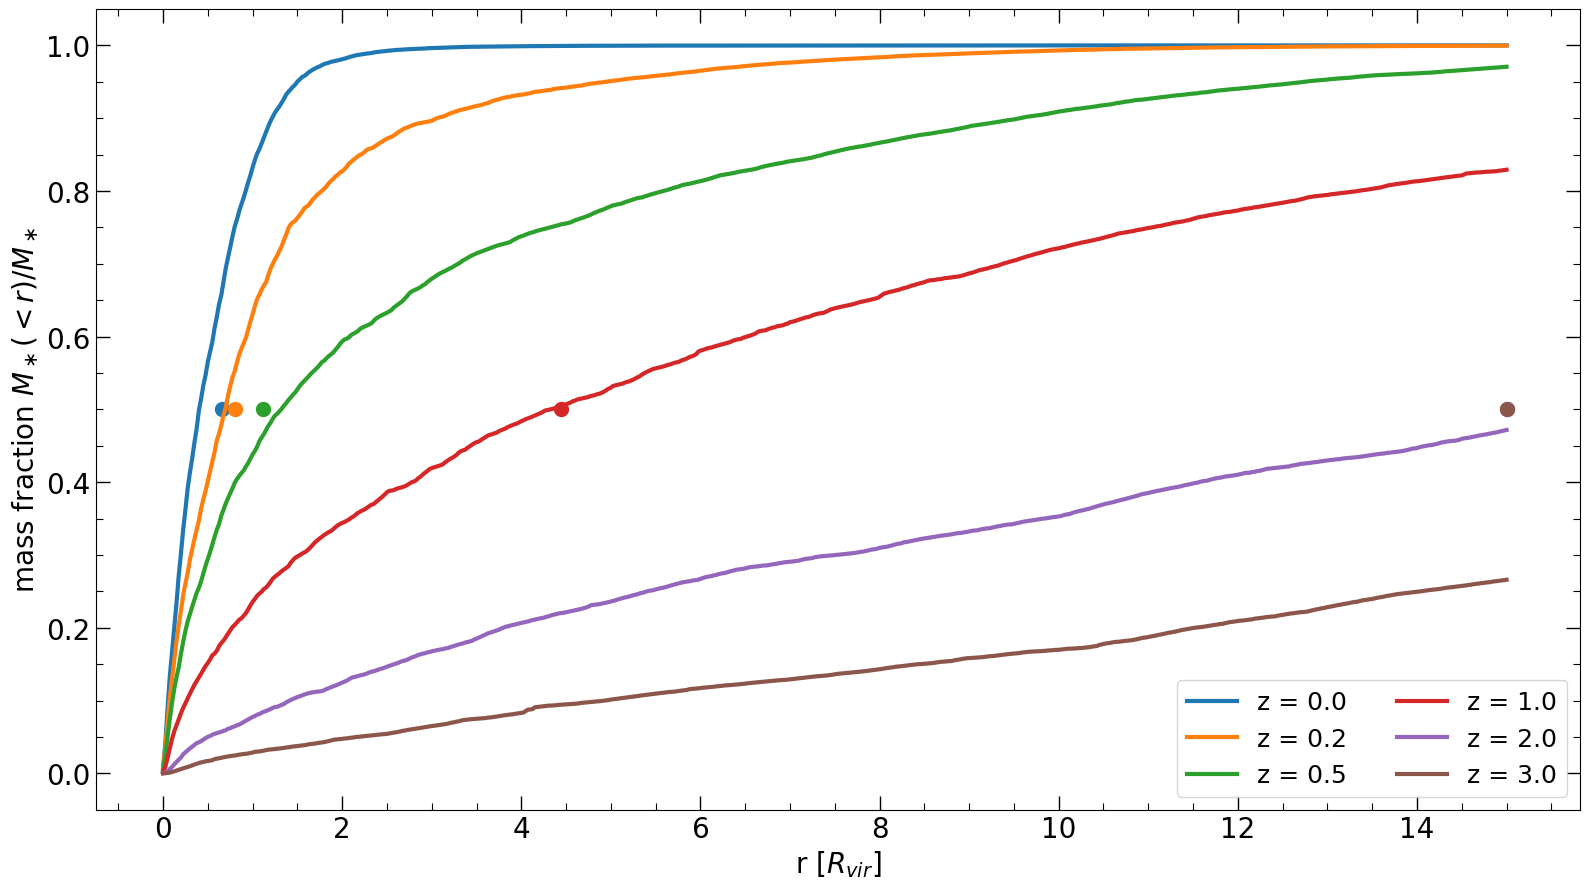

In [10]:
max_dist = 'new'
file = '/vera/ptmp/gc/olwitt/TNG50-' + run + f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_99.hdf5'
#assert isfile(file), 'filename wrong'
f = h5py.File(file,'r')
profiles = f['cumulative_profiles'][:,:]
dist_bins = f['distance_bins'][:]
f.close()
print(min(dist_bins), max(dist_bins))
f = h5py.File('files/TNG50-' + str(run) + f'/hmr_form_snap_{max_dist}.hdf5','r')
hmr = f['halfmass_radii'][:,:]
form_snap = f['formation_snapshots'][:]
f.close()

# f = h5py.File(basePath[:-6]+'postprocessing/HaloAssemblyTimes/Group_HaloAssembly_099.hdf5 ','r')
# z_form_50 = f['z50'][:]
# f.close()

snaps = np.array([99,84,67,50,33,25])
z_snaps = np.flip(z)[snaps]

cumsum_profiles = np.empty((snaps.shape[0],profiles.shape[0],profiles.shape[1]), dtype = float)
masks = {}
for i in range(snaps.size):
    f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
                  f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_{snaps[i]}.hdf5','r')
    profiles = f['cumulative_profiles'][:,:]
    extrapolated_sub_ids = f['which_galaxy_ids'][:]
    f.close()
    if profiles.shape[0] != cumsum_profiles.shape[1]:
        #if there are less profiles in the snapshot file than at snap99: add -1 arrays so the shapes match again
        diff = cumsum_profiles.shape[1] - profiles.shape[0]
        counter = 0
        for j in range(cumsum_profiles.shape[1]):
            if extrapolated_sub_ids[j] == -1:
                cumsum_profiles[i,j,:] = np.full(cumsum_profiles.shape[2],-1)
                diff -= 1
            else:
                cumsum_profiles[i,j,:] = profiles[counter,:]
                counter += 1
        #assert counter == profiles.shape[0] and diff == 0, 'filling went wrong'
    else:
        cumsum_profiles[i,:,:] = profiles
    #no np.where extra == -1 necessary because those won't be found in the other getIndices function -> will be excluded
    # by default
    #but snapshot dependece of masks is given, since extra changes with every snapshot
    masks[0,i] = tF.getIndices(tF.getIndices(sub_ids_dwarves, all_central_ids),\
                             extrapolated_sub_ids)
    masks[1,i] = tF.getIndices(tF.getIndices(sub_ids_mw, all_central_ids),\
                             extrapolated_sub_ids)
    masks[2,i] = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids),\
                             extrapolated_sub_ids)

#print(masks)

#for now, compute the median z50 for all dwarfs, mws and groups
# z_form_halos = np.zeros(3)
# z_form_halos[0] = np.nanmedian(z_form_50[dwarf_ids])
# z_form_halos[1] = np.nanmedian(z_form_50[mw_ids])
# z_form_halos[2] = np.nanmedian(z_form_50[group_ids])


fig, ax = plt.subplots(1,1,figsize = (16,9),tight_layout=True)
for i in range(snaps.shape[0]):
    mask = np.where(np.all(cumsum_profiles[i,masks[1,i],:] >= 0,axis=1))[0]
    ax.plot(dist_bins, np.nanmedian(cumsum_profiles[i,masks[0,i],:][mask,:], axis=0),\
                 label = f'z = {z_snaps[i]:.1f}')
    ax.scatter(np.nanmedian(hmr[99-snaps[i],masks[1,i]][mask]),0.5)
#mask = np.where(np.all(cumsum_profiles[0,mask_dwarves,:] >= 0,axis=1))[0]
#ax.text(3,0.2,r'$z_{form}$ = ' + f'{z[99-np.nanmedian(form_snap[masks[0,0]]).astype(int)]:.1f}',size = 20)


ax.legend(ncol = 2,loc='lower right')

ax.set_ylabel(r'mass fraction $M_\ast(<r)/M_\ast$')
ax.set_xlabel('r [$R_{vir}$]')
fig.tight_layout()

#plt.savefig('pics/radial_profiles/esa_interview_pic_big.png',format='png')

In [5]:
f = h5py.File('files/TNG50-' + str(run) + '/hmr_form_snap.hdf5','r')
hmr = f['halfmass_radii'][:,:]
form_snap = f['formation_snapshots'][:]
f.close()
snaps = np.arange(99,0,-1)
for i in range(snaps.size):
    f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
                  f'/cumulative_radial_profile/rad_prof_tracer_frac_new_all_{snaps[i]}.hdf5','r')
    extrapolated_sub_ids = f['which_galaxy_ids'][:]
    f.close()
    masks[0,i] = tF.getIndices(tF.getIndices(sub_ids_dwarves, all_central_ids),\
                             extrapolated_sub_ids)
    masks[1,i] = tF.getIndices(tF.getIndices(sub_ids_mw, all_central_ids),\
                             extrapolated_sub_ids)
    masks[2,i] = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids),\
                             extrapolated_sub_ids)


In [12]:
print(masks[2,98])

[ 5 11 12 14 16 17 18 19 20 21 22 23 24 25 26 27 28 30 31 33 34 35 37 39
 40 41 43 44 46 48 53]


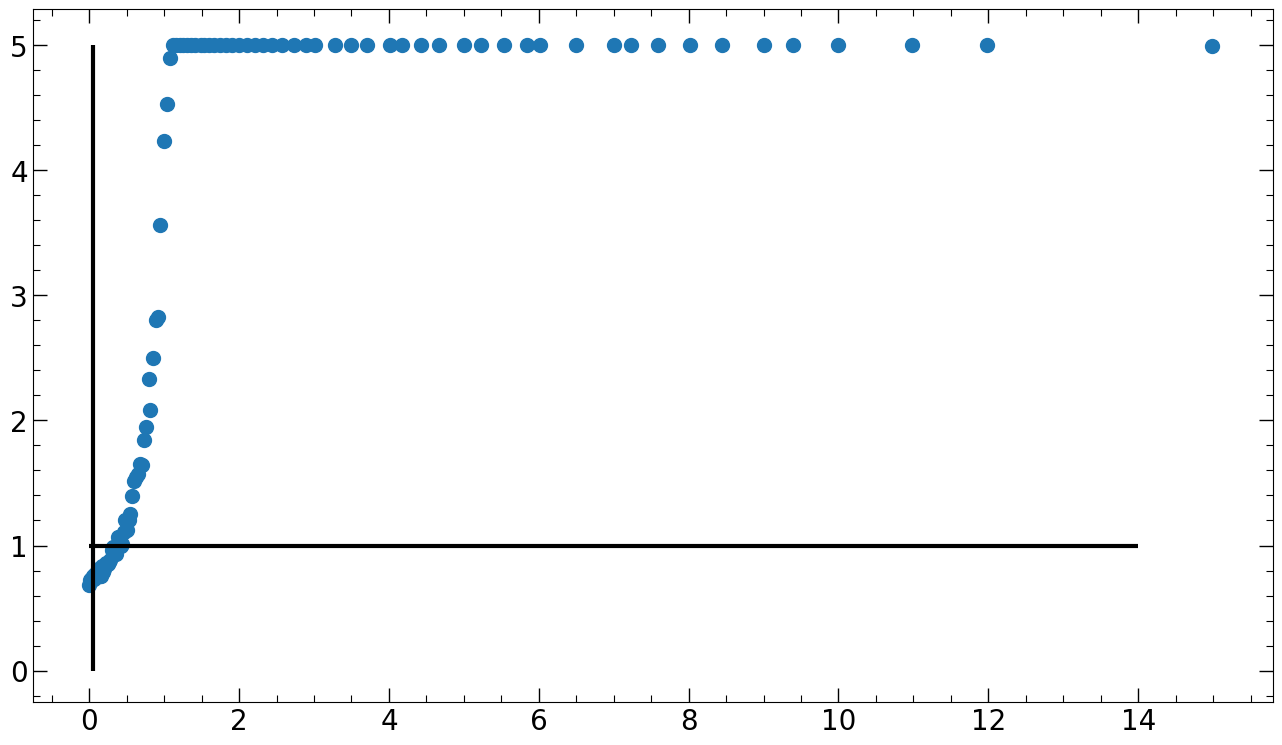

In [24]:
for i in range(snaps.size):
    plt.scatter(z[i],np.nanmedian(hmr[i,masks[1,i]]),marker='o',color = 'tab:blue')
plt.vlines(np.nanmedian(z[99-form_snap[masks[1,0]].astype(int)]),0,5)
plt.hlines(1,0,14)

## single galaxies:

110036 110476 110036 110036 110036 110036 

78194 80012 80012 78194 78194 78194 

44480 44480 44480 44480 44480 44480 

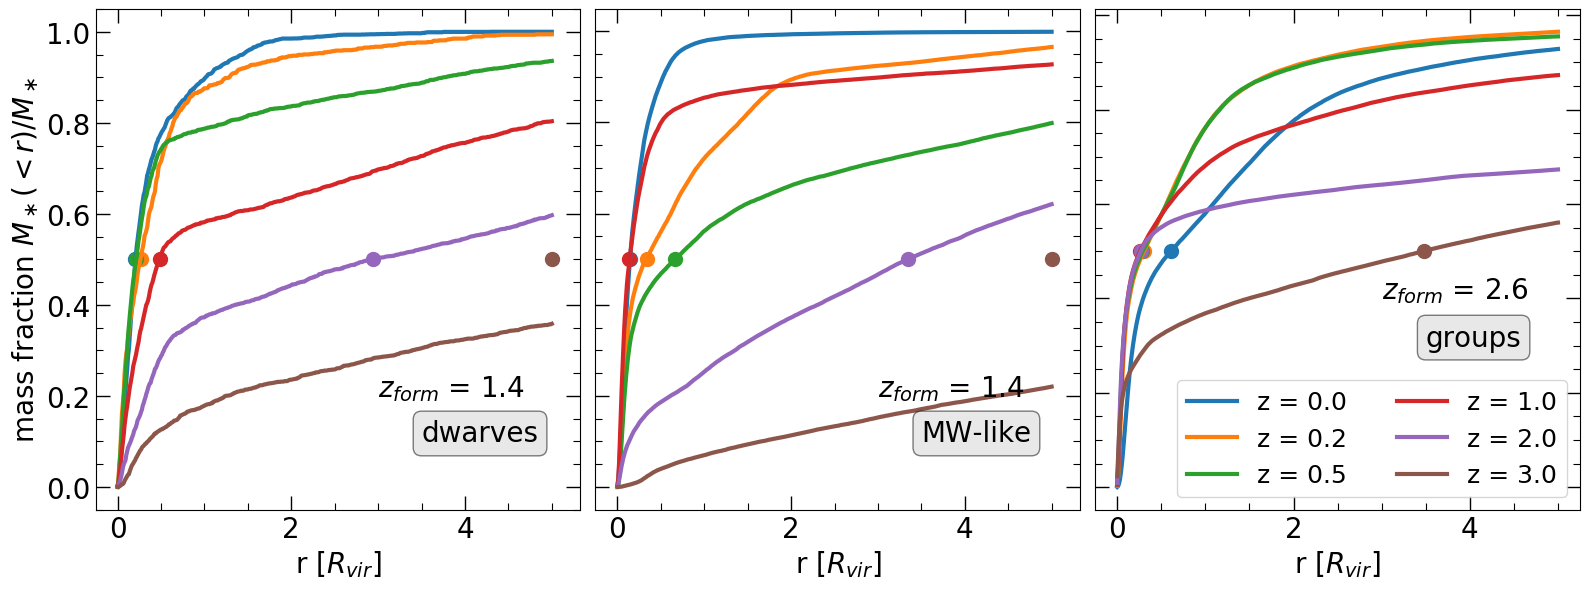

In [8]:
file = '/vera/ptmp/gc/olwitt/TNG50-' + run + '/cumulative_radial_profile/rad_prof_tracer_frac_new_all_99.hdf5'
#assert isfile(file), 'filename wrong'
f = h5py.File(file,'r')
profiles = f['cumulative_profiles'][:,:]
dist_bins = f['distance_bins'][:]
f.close()

f = h5py.File('files/TNG50-' + str(run) + '/hmr_form_snap.hdf5','r')
hmr = f['halfmass_radii'][:,:]
form_snap = f['formation_snapshots'][:]
f.close()

snaps = np.array([99,84,67,50,33,25])
z_snaps = np.flip(z)[snaps]

sub_ids = all_central_ids[np.where(all_central_ids != -1)]

cumsum_profiles = np.empty((snaps.shape[0],profiles.shape[0],profiles.shape[1]), dtype = float)
masks = {}
for i in range(snaps.size):
    f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
                  f'/cumulative_radial_profile/rad_prof_tracer_frac_new_all_{snaps[i]}.hdf5','r')
    profiles = f['cumulative_profiles'][:,:]
    extrapolated_sub_ids = f['which_galaxy_ids'][:]
    f.close()
    if profiles.shape[0] != cumsum_profiles.shape[1]:
        #if there are less profiles in the snapshot file than at snap99: add -1 arrays so the shapes match again
        diff = cumsum_profiles.shape[1] - profiles.shape[0]
        counter = 0
        for j in range(cumsum_profiles.shape[1]):
            if extrapolated_sub_ids[j] == -1:
                cumsum_profiles[i,j,:] = np.full(cumsum_profiles.shape[2],-1)
                diff -= 1
            else:
                cumsum_profiles[i,j,:] = profiles[counter,:]
                counter += 1
#         assert counter == profiles.shape[0] and diff == 0, 'filling went wrong'
    else:
        cumsum_profiles[i,:,:] = profiles
    masks[0,i] = tF.getIndices(tF.getIndices(sub_ids_dwarves, all_central_ids),\
                                 extrapolated_sub_ids)
    masks[1,i] = tF.getIndices(tF.getIndices(sub_ids_mw, all_central_ids),\
                                 extrapolated_sub_ids)
    masks[2,i] = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids),\
                                     extrapolated_sub_ids)

#print(masks)

ids = 2
fig, ax = plt.subplots(1,3,figsize = (16,6),tight_layout=True)
for i in range(snaps.shape[0]):
    #mask = np.where(np.all(cumsum_profiles[i,masks[0,i],:] >= 0,axis=1))[0]
    ax[0].plot(dist_bins, cumsum_profiles[i,masks[0,i][ids],:],\
                 label = f'z = {z_snaps[i]:.1f}')
    ax[0].scatter(hmr[99-snaps[i],masks[0,i][ids]],0.5)
    print(sub_ids[extrapolated_sub_ids[masks[0,i][ids]]],end = ' ')
ax[0].text(3,0.2,r'$z_{form}$ = ' + f'{z[99-form_snap[masks[0,0][ids]].astype(int)]:.1f}',size = 20)
print('\n')
for i in range(snaps.shape[0]):
    #mask = np.where(np.all(cumsum_profiles[i,masks[1,i],:] >= 0,axis=1))[0]
    ax[1].plot(dist_bins, cumsum_profiles[i,masks[1,i][ids],:], label = f'z = {z_snaps[i]:.1f}')
    ax[1].scatter(hmr[99-snaps[i],masks[1,i][ids]],0.5)
    print(sub_ids[extrapolated_sub_ids[masks[1,i][ids]]],end = ' ')
ax[1].text(3,0.2,r'$z_{form}$ = ' + f'{z[99-form_snap[masks[1,0][ids]].astype(int)]:.1f}', size = 20)
print('\n')
for i in range(snaps.shape[0]):
    #mask = np.where(np.all(cumsum_profiles[i,masks[2,i],:] >= 0,axis=1))[0]
    ax[2].plot(dist_bins, cumsum_profiles[i,masks[2,i][ids],:], label = f'z = {z_snaps[i]:.1f}')
    ax[2].scatter(hmr[99-snaps[i],masks[2,i][ids]],0.5)
    print(sub_ids[extrapolated_sub_ids[masks[2,i][ids]]],end = ' ')
ax[2].text(3,0.4,r'$z_{form}$ = ' + f'{z[99-form_snap[masks[2,0][ids]].astype(int)]:.1f}', size = 20)
    
ax[0].text(3.5,0.1,'dwarves', size = 20, bbox=\
             dict(boxstyle="round",ec='black',fc='lightgray',alpha = 0.5))
ax[1].text(3.5,0.1,'MW-like', size = 20, bbox=\
             dict(boxstyle="round",ec='black',fc='lightgray',alpha = 0.5))
ax[2].text(3.5,0.3,'groups', size = 20, bbox=\
             dict(boxstyle="round",ec='black',fc='lightgray',alpha = 0.5))





ax[2].legend(ncol = 2,loc='lower right')

ax[0].set_ylabel(r'mass fraction $M_\ast(<r)/M_\ast$')
ax[0].set_xlabel('r [$R_{vir}$]')
ax[1].set_xlabel('r [$R_{vir}$]')
ax[2].set_xlabel('r [$R_{vir}$]')
# ax[1,0].set_ylabel(r'mass fraction $M_\ast(<r)/M_\ast$')
# ax[1,1].set_xlabel(r'halo mass [log $\rm{M}_\odot$]')
# ax[1,1].set_ylabel(r'$\rm{R}_{0.5}$ [$\rm{R}_{vir}$]')

# ax[0,0].tick_params(labelbottom=False)
ax[1].tick_params(labelleft=False)
ax[2].tick_params(labelleft=False)
fig.tight_layout()

#plt.savefig('pics/rad_dist_profile_w_mass_bins_TNG50-2_cumulative_rvir_at_snap.pdf',format='pdf')

In [37]:
print(z[99-int(form_snap[686])])

1.074457894547674


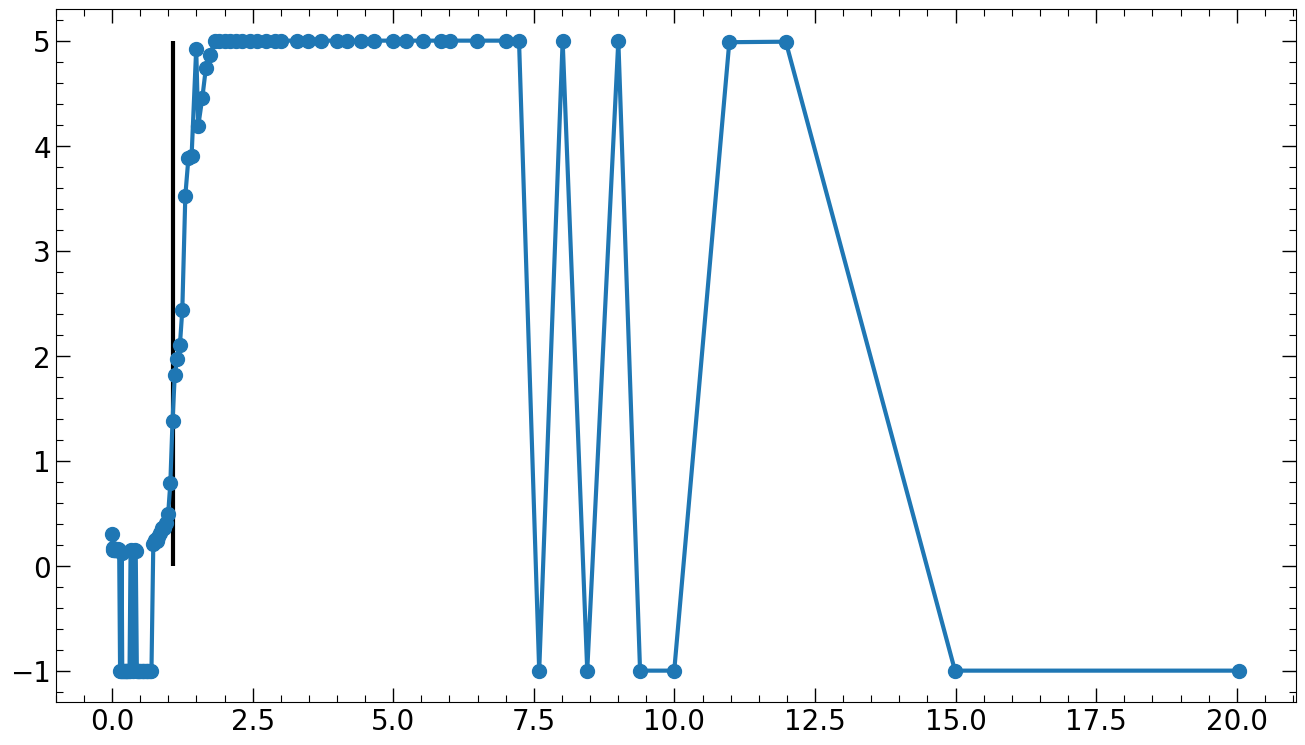

In [7]:
sub_id = 71
plt.plot(z[:],hmr[:,sub_id],marker='o')
plt.vlines(z[99-int(form_snap[sub_id])],0,5)

# summary statistic

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


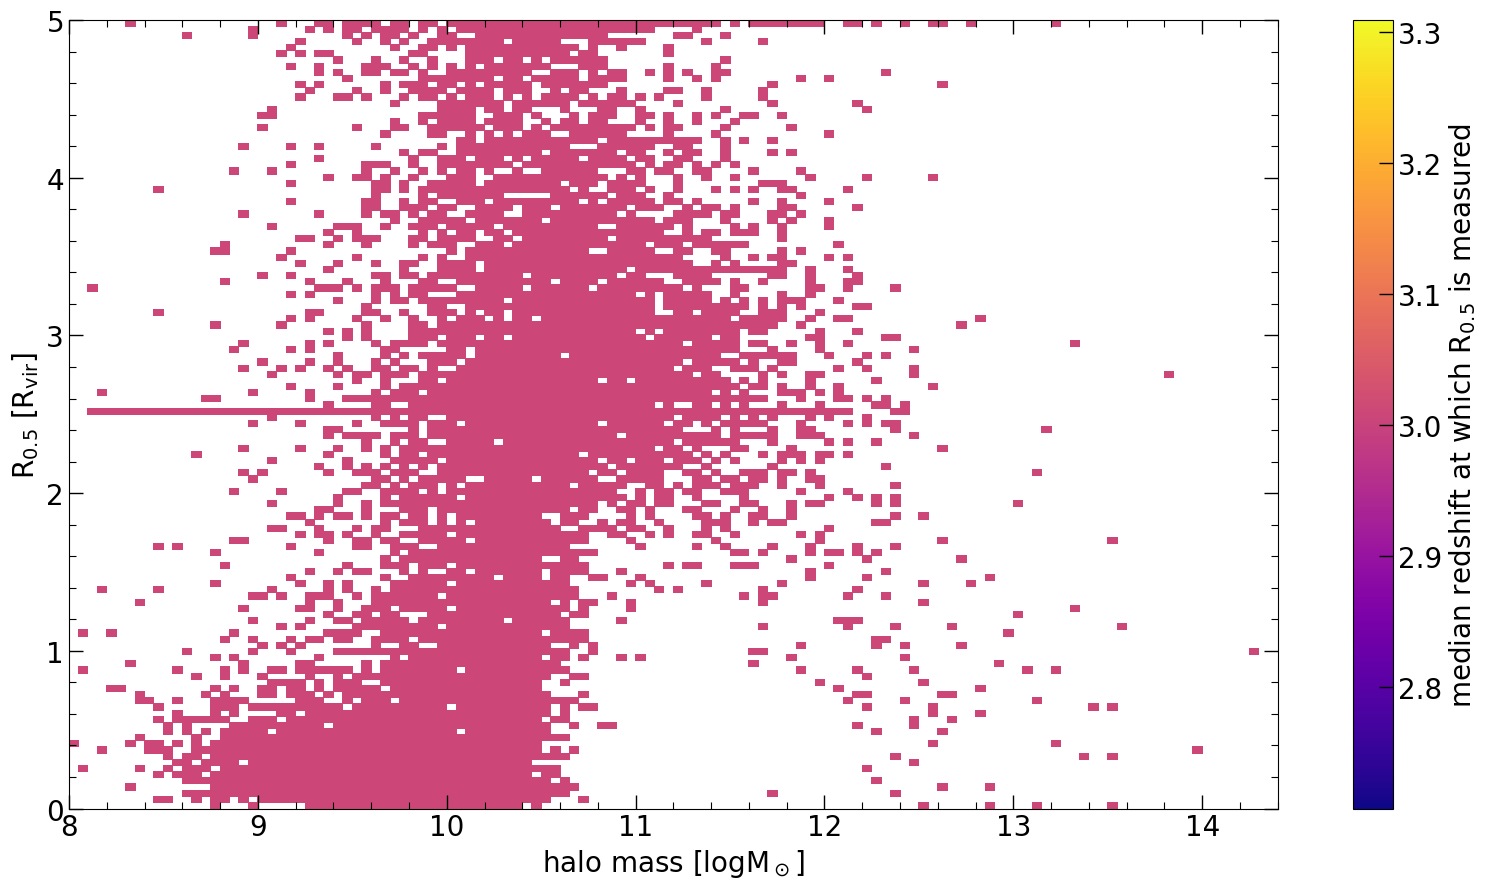

In [80]:
masses = group_masses[extrapolated_sub_ids]
mass_mask = np.where(np.isfinite(masses))[0]
statistic, x, y, binnumber = binned_statistic_2d(masses[mass_mask],hmr[0,mass_mask],z_snaps[0]\
                                                 * np.ones(mass_mask.shape[0]), 'median', bins = (128,128),\
                                                 range = [[8,14.4],[0,5]], expand_binnumbers = True)
all_statistics = np.zeros((6,statistic.shape[0],statistic.shape[1]))
all_statistics[0,:,:] = statistic
for i in range(1,snaps.size):
    all_statistics[i,:,:], _, _, binnumber = binned_statistic_2d(masses[mass_mask],hmr[i,mass_mask],z_snaps[i] *\
                                                        np.ones(mass_mask.shape[0]), 'median', bins = (128,128),\
                                                        range = [[8,14.4],[0,5]], expand_binnumbers = True)
all_statistics_med = np.nanmedian(all_statistics, axis = 0)
#bounds = np.array([-0.1,0.1,0.3,0.7,1.5,2.5,3.5])
im = plt.pcolormesh(x,y,all_statistics[5].T,cmap = 'plasma', shading='auto')
plt.xlabel(r'halo mass [log$\rm{M}_\odot$]')
plt.ylabel(r'$\rm{R}_{0.5}$ [$\rm{R}_{vir}$]')
with mpl.rc_context({'ytick.minor.visible' : False}):
    plt.colorbar(mappable = im, label = r'median redshift at which $\rm{R}_{0.5}$ is measured')#\
    #, boundaries = bounds, values=z_snaps, ticks = np.round(z_snaps,1))
plt.tight_layout()
#plt.savefig('pics/hmr_vs_mass_50-2.pdf',format='pdf')

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


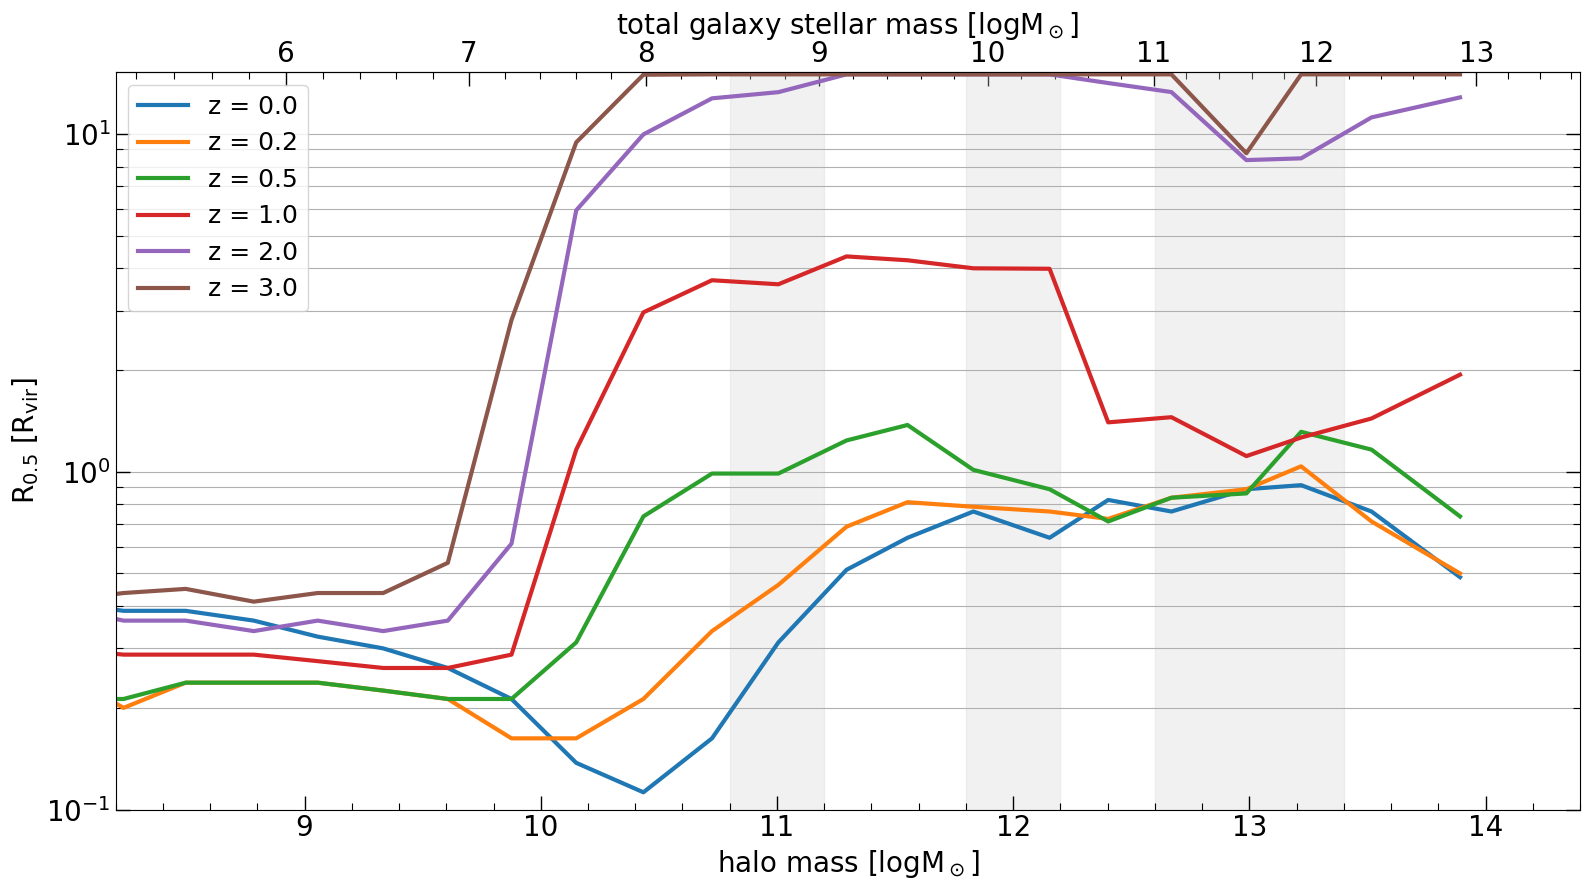

In [112]:
#compute median stellar mass halo mass relation
def stellar_to_halo_mass_relation(stellar_masses):
    #return 4.3067e-4 * stellar_masses**3.6621 +9.5446
    return 1.2190 * stellar_masses**0.8 + 3.8777

def halo_to_stellar_mass_relation(halo_masses):
    #return 0.0482 * halo_masses**2.0828 + 1.9446
    return 2.7952 * halo_masses**0.8 - 9.9540

#compute median stellar mass halo mass relation
# def stellar_to_halo_mass_relation(stellar_masses):
#     #return 0.0191 * stellar_masses**3 + - 0.4622 * stellar_masses**2 + 4.2273 * stellar_masses - 3.6001
#     return 0.0881 * stellar_masses**2 - 0.4308 * stellar_masses + 4.0569

# def halo_to_stellar_mass_relation(halo_masses):
#     #return -0.1829 * halo_masses**3 + 6.3156 * halo_masses**2 - 71.030 * halo_masses + 269.5462
#     return 0.0804 * halo_masses**2 - 1.0318 * halo_masses + 13.0392
max_dist = 'new'
f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
              f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_1.hdf5','r')
extrapolated_sub_ids = f['which_galaxy_ids'][:]
f.close()
#print(np.where(extrapolated_sub_ids != -1)[0].shape[0])

f = h5py.File('/vera/ptmp/gc/olwitt/TNG50-' + run +\
              f'/cumulative_radial_profile/rad_prof_tracer_frac_{max_dist}_all_99.hdf5','r')
extrapolated_sub_ids = f['which_galaxy_ids'][:]
f.close()

all_sub_means = {}
for snap in snaps:
    filename = f'/vera/ptmp/gc/olwitt/TNG50-{run}/cumulative_radial_profile/\
rad_prof_tracer_frac_{max_dist}_all_{snap}.hdf5'
    f = h5py.File(filename,'r')
    all_sub_means[snap] = f['subhalo_mean_distances'][:]
    f.close()

group_masses = np.log10(groups['Group_M_Crit200']*1e10/h_const)

#take all halos where GroupFirstSub != -1
halo_ids = np.arange(all_central_ids.shape[0])[np.where(all_central_ids != -1)]

#now take halos where the central galaxy is good according to extrapolated_sub_ids
mass_ind = halo_ids[extrapolated_sub_ids[np.where(extrapolated_sub_ids != -1)]]
masses = group_masses[mass_ind]
mass_mask = np.where(np.isfinite(masses))[0]

with mpl.rc_context({'xtick.top' : False}): 
    fig,ax = plt.subplots(1,1)
for i in range(0,snaps.size):
    xmed, ymed, y16,y84 = funcs.binData_med(masses[mass_mask],hmr[99-snaps[i],mass_mask],25)
    xmed2, ymed2, y162,y842 = funcs.binData_med(masses[mass_mask],\
                                                np.take(all_sub_means[snaps[i]],mass_mask.astype(int),mode = 'clip'),25)
    ax.plot(xmed,ymed,label = f'z = {z_snaps[i]:.1f}',color = 'C'+str(i))
    #ax.plot(xmed2,ymed2,linestyle='dashed',color = 'C'+str(i),alpha = 0.3)
    #plt.plot(xmed2,ymed2,linestyle = '--')
# print(xmed)
# print(halo_to_stellar_mass_relation(xmed))
# xmed, ymed, y16,y84 = funcs.binData_med(masses[mass_mask],hmr[92,mass_mask],30)
# plt.plot(xmed,ymed,label = f'z = {z[92]:.1f}',color='black')
secax = ax.secondary_xaxis('top',functions = (halo_to_stellar_mass_relation,stellar_to_halo_mass_relation ))
secax.set_xlabel(r'total galaxy stellar mass [log$\rm{M}_\odot$]')

rec_dwarf = Rectangle((10.8,-0.2),0.4,19, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_dwarf)
rec_mw = Rectangle((11.8,-0.2),0.4,19, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_mw)
rec_group = Rectangle((12.6,-0.2),0.8,19, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_group)
ax.set_xlim(8.2,14.4)    
ax.set_ylim(0.1,15.2)
ax.set_yscale('log')
plt.grid(which = 'both',axis = 'y')
plt.legend()
plt.xlabel(r'halo mass [log$\rm{M}_\odot$]')
plt.ylabel(r'$\rm{R}_{0.5}$ [$\rm{R}_{vir}$]')
plt.tight_layout()
#plt.savefig('pics/halfmass_radii/hmr_vs_mass_50-1_r_vir_at_snap.pdf',format='pdf')

In [42]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
f = h5py.File('files/' + basePath[32:39] + '/hmr_form_snap.hdf5','r')
form_snap = f['formation_snapshots'][:]
f.close()

f = h5py.File(basePath[:-6]+'postprocessing/HaloAssemblyTimes/Group_HaloAssembly_099.hdf5','r')
check = f['Done'][:]
z_form_50 = f['z50'][:]
f.close()

# f = h5py.File(basePath[:-6]+'postprocessing/halo_structure/halo_structure_099.hdf5','r')
# check = f['GroupFlag'][:]
# a_form = f['a_form'][:]
# check_masses = f['M200c'][:]
# f.close()
# z_form = 1/a_form - 1

f = h5py.File('files/' + basePath[32:39] + '/halo_formation_times.hdf5','r')
halo_z_form = f['formation_redshift'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + '/cumulative_radial_profile/rad_prof_tracer_frac_new_all_99.hdf5','r')
extrapolated_sub_ids = f['which_galaxy_ids'][:]
f.close()

In [32]:
h_const = il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

#introduce mass bins:
groups = il.groupcat.loadHalos(basePath, 99, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))[0]
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))[0]
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))[0]
all_ids = np.arange(group_masses.shape[0])

group_masses = np.log10(group_masses)

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]
all_central_ids = groups['GroupFirstSub'][:]

z = iF.give_z_array(basePath)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [44]:
halo_ids = np.arange(all_central_ids.shape[0])[np.where(all_central_ids != -1)[0]][extrapolated_sub_ids[np.where(extrapolated_sub_ids != -1)]]
print(halo_ids[:100])
print(extrapolated_sub_ids[:400])
print(all_central_ids[:100])

[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  53  54  55  56  58  59
  60  61  62  64  65  66  67  68  70  72  73  74  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98 100
 101 102 103 104 105 106 107 108 110 111]
[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  -1  25  26  27  28  29  30  31  32  33  -1  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  -1  53  54  55
  56  58  59  60  61  62  -1  64  65  66  67  68  -1  70  -1  72  73  74
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  -1 100 101 102 103 104 105 106 107 108  -1 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
  -1 149 

In [26]:
print(min(group_masses[halo_ids]))

7.175327


In [49]:
print(form_snap.shape)
print(z_form_50[halo_ids].shape)
print(halo_z_form[tF.getIndices(np.nonzero(check)[0],halo_ids)].shape)

(33980,)
(33980,)
(33980,)


In [12]:
print(z[99-form_snap[:10].astype(int)])
print(z_form_50[halo_ids[:10]])

[1.20625808 1.53123903 0.19728418 0.44029785 1.24847261 0.21442504
 0.0994018  3.70877426 0.75744137 0.18038526]
[0.76 1.6  2.   0.62 2.   2.1  2.   1.8  4.2  1.8 ]


In [34]:
mask0 = tF.getIndices(tF.getIndices(sub_ids_dwarves, all_central_ids),\
                             extrapolated_sub_ids)
print(np.nanmedian(z_form_50[halo_ids[mask0]]))
mask1 = tF.getIndices(tF.getIndices(sub_ids_mw, all_central_ids),\
                             extrapolated_sub_ids)
print(np.nanmedian(z_form_50[halo_ids[mask1]]))
mask2 = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids),\
                             extrapolated_sub_ids)
print(np.nanmedian(z_form_50[halo_ids[mask2]]))

1.5
1.4
0.835


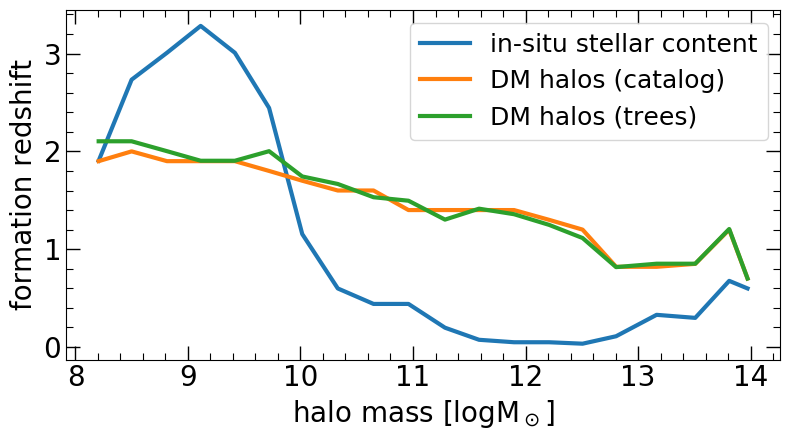

In [84]:
fig, ax = plt.subplots(figsize=(8,4.5))
group_masses_masked = group_masses[halo_ids]
z_form_50_masked = z[99-form_snap.astype(int)]#[halo_ids]

mask11 = np.where(group_masses_masked > 8)[0]
group_masses_masked = group_masses_masked[mask11]
z_form_50_masked = z_form_50_masked[mask11]
mask12 = np.where(np.isfinite(z_form_50_masked))[0]
group_masses_masked = np.take(group_masses_masked,mask12,mode='clip')
z_form_50_masked = z_form_50_masked[mask12]
#print(z_form_50_masked[0])

xmed,ymed,_,_ = funcs.binData_med(group_masses_masked,z_form_50_masked,20)
plt.plot(xmed,ymed,color='tab:blue',label = 'in-situ stellar content')

group_masses_masked = group_masses[halo_ids]
z_form_50_masked = z_form_50[tF.getIndices(np.nonzero(check)[0],halo_ids)]

mask11 = np.where(group_masses_masked > 8)[0]
group_masses_masked = group_masses_masked[mask11]
z_form_50_masked = z_form_50_masked[mask11]
mask12 = np.where(np.isfinite(z_form_50_masked))[0]
group_masses_masked = group_masses_masked[mask12]
z_form_50_masked = z_form_50_masked[mask12]
#print(z_form_50_masked[0])

xmed2,ymed2,_,_ = funcs.binData_med(group_masses_masked,z_form_50_masked,20)
plt.plot(xmed2,ymed2,color='tab:orange',label = 'DM halos (catalog)')

group_masses_masked = group_masses[halo_ids]
z_form_50_masked = np.take(halo_z_form,halo_ids,mode='clip')

mask11 = np.where(group_masses_masked > 8)[0]
group_masses_masked = group_masses_masked[mask11]
z_form_50_masked = z_form_50_masked[mask11]
mask12 = np.where(np.isfinite(z_form_50_masked))[0]
group_masses_masked = group_masses_masked[mask12]
z_form_50_masked = z_form_50_masked[mask12]
#print(z_form_50_masked[0])

xmed3,ymed3,_,_ = funcs.binData_med(group_masses_masked,z_form_50_masked,20)
plt.plot(xmed3,ymed3,color='tab:green',label = 'DM halos (trees)')
#plt.ylim(0,7)
#plt.xlim(8.5,14.3)
plt.xlabel(r'halo mass [log$\rm{M}_\odot$]')
plt.ylabel('formation redshift')
plt.legend()
plt.tight_layout()
#plt.savefig('pics/formation_times/halo_form_z_vs_insitu_form_50-1_small.pdf',format = 'pdf')

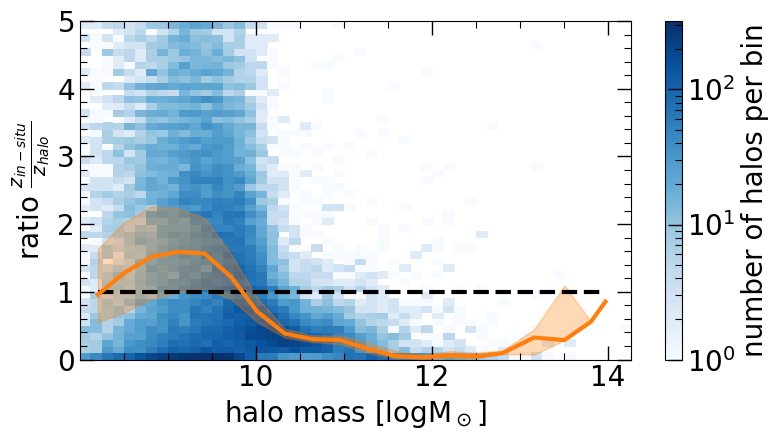

In [109]:
#in-situ formation times:
group_masses_masked = group_masses[halo_ids]
z_form_insitu = z[99-form_snap.astype(int)] #enter formation snapshots
mask11 = np.where(group_masses_masked > 8)[0]
group_masses_masked = group_masses_masked[mask11]
z_form_insitu = z_form_insitu[mask11]
mask12 = np.where(np.isfinite(z_form_insitu))[0]
group_masses_masked = np.take(group_masses_masked,mask12,mode='clip')
z_form_insitu = z_form_insitu[mask12]

#halo formation times
group_masses_masked2 = group_masses[halo_ids]
z_form_halo = np.take(halo_z_form,halo_ids,mode='clip')
mask11 = np.where(group_masses_masked2 > 8)[0]
group_masses_masked2 = group_masses_masked2[mask11]
z_form_halo = z_form_halo[mask11]
mask12 = np.where(np.isfinite(z_form_halo))[0]
group_masses_masked2 = group_masses_masked2[mask12]
z_form_halo = z_form_halo[mask12]

fig,ax = plt.subplots(figsize = (8,4.5))
ratio = z_form_insitu/z_form_halo
final_mask = np.where(ratio < 5)[0]
plt.hist2d(group_masses_masked[final_mask],ratio[final_mask],bins = 50,norm = mpl.colors.LogNorm(),cmap = 'Blues',\
          shading='auto',linewidth=0,rasterized=True)
plt.colorbar(label = 'number of halos per bin')

xmed,ymed,y16,y84 = funcs.binData_med(group_masses_masked,ratio,20,40,60)

plt.plot(xmed,ymed,color='tab:orange')
plt.fill_between(xmed,y16,y84,alpha = 0.3, color = 'tab:orange')
plt.hlines(1,min(xmed),max(xmed),linestyle = 'dashed')


plt.ylim(0,5)
plt.xlabel(r'halo mass [log$\rm{M}_\odot$]')
plt.ylabel(r'ratio $\frac{z_{in-situ}}{z_{halo}}$')
plt.tight_layout()
#plt.savefig('pics/formation_times/halo_insitu_ratio_50-1_small.pdf',format = 'pdf')